# Combine the features from Fei and Severson and test the data

## 1. Preparation and load the data

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from time import time

# Import Uncertainty Toolbox
import uncertainty_toolbox as uct

# library for hparams tuning
import scipy.stats as stats

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.metrics import _scorer, mean_squared_error, mean_absolute_percentage_error
from sklearn.utils.fixes import loguniform
import sklearn.gaussian_process as gp
from sklearn import linear_model

In [2]:
df_train_severson = pd.read_csv('data/MIT/wichtig/df_severson_feat_standard_samesplit_train.csv')
df_test_severson = pd.read_csv('data/MIT/wichtig/df_severson_feat_standard_samesplit_test.csv')
df_train_fei = pd.read_csv("data/MIT/wichtig/train_battery.csv")
df_test_fei = pd.read_csv("data/MIT/wichtig/test_battery.csv")

## 2. Concatenate the DataFrame

In [12]:
df_test_fei_sorted = df_test_fei.sort_values(by=['battery'], ignore_index=True)
df_test_fei_sorted

,rul_80%,rul_0.88Ah,F7,F8,F9,F17,F24,F34,F38,battery,index
0,2200,2158,0.012635,0.000156,3.354756e-07,-0.003862,1.084750,-0.507659,29.559613,b1c1,9
1,799,788,0.025802,0.001386,1.091419e-05,-0.019933,1.095767,0.099653,30.129886,b1c19,61
2,1036,1016,0.019783,0.000822,5.588335e-06,-0.014949,1.081735,-0.107250,30.499349,b1c24,100
3,855,842,0.021286,0.001051,6.986596e-06,-0.017165,1.086879,0.151039,30.730388,b1c27,99
4,760,756,0.028755,0.002289,1.011810e-05,-0.022630,1.101219,0.175403,30.366529,b1c33,110
5,757,743,0.016283,0.001259,6.690438e-06,-0.016962,1.084486,-0.092619,29.990527,b1c34,112
6,1090,1073,0.016923,0.000987,3.218835e-06,-0.012039,1.086188,-0.161300,29.240467,b1c5,18
7,508,501,-0.016496,0.002174,1.206272e-05,-0.023113,1.098220,-0.069535,30.265128,b2c20,19
8,520,512,0.029978,0.002300,1.243625e-05,-0.024226,1.094014,0.130447,29.948448,b2c22,21
9,509,495,0.011368,0.001397,6.769325e-06,-0.017735,1.079291,-0.411445,28.441437,b2c24,30


In [13]:
df_test_severson_sorted = df_test_severson.sort_values(by=['battery'], ignore_index=True)
df_test_severson_sorted

,slope_2_100,intercept_2_100,slope_91_100,disC_2,disC_max_2,disC_100,battery,RuL_0.88Ah
0,0.340614,0.604578,0.381645,0.518390,1.379763,0.639163,b1c1,2158.0
1,0.174431,1.480932,0.205859,1.533607,-0.239929,1.057501,b1c19,786.0
2,0.285492,0.301476,0.341776,0.365800,-0.043527,0.421880,b1c24,1015.0
3,0.171968,0.801053,0.311988,0.860930,-0.337276,0.653333,b1c27,840.0
4,0.077764,2.306436,0.207462,2.356488,-0.373693,1.506709,b1c33,755.0
5,0.259822,0.535625,0.343477,0.593153,-0.050935,0.550246,b1c34,740.0
6,0.372710,0.490380,0.323096,0.528286,0.691390,0.573418,b1c5,1072.0
7,0.204798,1.415727,0.069121,1.362305,0.845588,1.004139,b2c20,500.0
8,0.189947,1.020566,0.054844,0.987030,0.573007,0.758622,b2c22,511.0
9,0.283154,-0.340545,0.160617,-0.335880,0.475359,-0.004742,b2c24,493.0


In [17]:
test_battery_severson = df_test_severson_sorted['battery'].values
test_battery_fei = df_test_fei_sorted['battery'].values
print('test batteries in two set are the same: \n', test_battery_fei==test_battery_severson)

test batteries in two set are the same: 
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]


In [18]:
df_combined_test = copy.deepcopy(df_test_severson_sorted)
columns_fei = list(df_test_fei_sorted.columns)
columns_fei_diff = copy.deepcopy(columns_fei)
for label in ['battery', 'index']:
    columns_fei_diff.remove(label)

In [19]:
for label in columns_fei_diff:
    df_combined_test[label] = df_test_fei_sorted[label]

In [20]:
df_combined_test.to_csv('data/MIT/wichtig/df_severson_fei_combined_test.csv', index=False)

In [21]:
df_train_fei_sorted = df_train_fei.sort_values(by=['battery'], ignore_index=True)
df_train_severson_sorted = df_train_severson.sort_values(by=['battery'], ignore_index=True)

In [22]:
df_combined_train = copy.deepcopy(df_train_severson_sorted)
for label in columns_fei_diff:
    df_combined_train[label] = df_train_fei_sorted[label]
df_combined_train

,slope_2_100,intercept_2_100,slope_91_100,disC_2,disC_max_2,disC_100,battery,RuL_0.88Ah,rul_80%,rul_0.88Ah,F7,F8,F9,F17,F24,F34,F38
0,0.413862,-0.007270,0.447831,-0.025883,1.137700,0.312724,b1c0,1850.0,1923,1861,0.006790,-0.000272,4.217867e-07,-0.003115,1.081451,-0.344591,29.344060
1,0.456402,-1.740162,0.372807,-1.843610,1.812125,-0.746893,b1c11,786.0,824,787,0.014662,-0.000364,3.731106e-06,-0.010020,1.064332,-0.256252,30.149011
2,0.506782,-0.047309,0.363180,-0.022320,1.414228,0.337727,b1c14,878.0,903,878,0.017193,0.000418,4.165067e-06,-0.013009,1.079921,-0.130541,30.080735
3,0.540326,-0.980669,0.355252,-1.037298,2.102924,-0.226269,b1c15,717.0,748,720,0.019556,-0.000059,4.384988e-06,-0.012342,1.071994,-0.038019,29.956462
4,0.481435,1.084307,0.321411,1.111320,1.423465,1.012172,b1c16,860.0,875,861,0.011822,0.000914,3.733116e-06,-0.013035,1.091786,-0.210994,29.841672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.255654,-0.381818,0.386156,-0.248023,-0.810024,-0.006333,b3c45,1799.0,1853,1801,0.008575,0.000330,1.564136e-06,-0.007724,1.073797,-1.145651,30.851857
94,0.123450,-2.279476,0.255809,-2.195790,-0.989478,-1.279827,b3c5,826.0,855,827,0.016686,0.000834,3.815892e-06,-0.012424,1.057421,-0.393916,32.261079
95,-1.510711,-1.220131,-0.901262,-1.089375,-2.013201,-1.832000,b3c6,665.0,708,666,0.029988,0.004818,1.598292e-05,-0.029899,1.081987,-1.608874,31.419502
96,0.232136,-0.746953,0.276353,-0.708833,-0.173263,-0.268049,b3c8,826.0,844,827,0.014537,0.000561,3.711122e-06,-0.012517,1.072869,-0.486695,31.261810


In [23]:
df_combined_train.to_csv('data/MIT/wichtig/df_severson_fei_combined_train.csv', index=False)

In [24]:
df_combined = pd.concat([df_combined_train, df_combined_test])
df_combined.to_csv('data/MIT/wichtig/df_severson_fei_combined.csv', index=False)

## 3. Test with GPR

### 3.1 Prepare the datas and model

In [9]:
df_combined_train = pd.read_csv('data/MIT/wichtig/df_severson_fei_combined_train.csv')
df_combined_test  = pd.read_csv('data/MIT/wichtig/df_severson_fei_combined_test.csv')
df_combined = pd.read_csv('data/MIT/wichtig/df_severson_fei_combined.csv')

X = df_combined.loc[:, ['slope_2_100', 'intercept_2_100', 'slope_91_100', 'disC_2', 'disC_max_2', 'disC_100', 'F8', 'F9', 'F17']].values
X_train = df_combined_train.loc[:, ['slope_2_100', 'intercept_2_100', 'slope_91_100', 'disC_2', 'disC_max_2', 'disC_100', 'F8', 'F9', 'F17']].values
y_train = df_combined_train['RuL_0.88Ah'].values

X_test = df_combined_test.loc[:, ['slope_2_100', 'intercept_2_100', 'slope_91_100', 'disC_2', 'disC_max_2', 'disC_100', 'F8', 'F9', 'F17']].values
y_test = df_combined_test['RuL_0.88Ah'].values

scaler = preprocessing.StandardScaler()
df_combined
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [10]:
X_test.shape

(25, 9)

In [25]:
from typing import Union, Tuple, List, Any, NoReturn
import matplotlib

def plot_xy(
    y_pred: np.ndarray,
    y_std: np.ndarray,
    y_true: np.ndarray,
    x: np.ndarray,
    n_subset: Union[int, None] = None,
    ylims: Union[Tuple[float, float], None] = None,
    xlims: Union[Tuple[float, float], None] = None,
    num_stds_confidence_bound: int = 2,
    leg_loc: Union[int, str] = 3,
    ax: Union[matplotlib.axes.Axes, None] = None,
) -> matplotlib.axes.Axes:

    # Create ax if it doesn't exist
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # Order points in order of increasing x
    order = np.argsort(y_true)
    y_pred, y_std, y_true, x = (
        y_pred[order],
        y_std[order],
        y_true[order],
        x[order],
    )

    # Optionally select a subset
    if n_subset is not None:
        [y_pred, y_std, y_true, x] = filter_subset([y_pred, y_std, y_true, x], n_subset)

    intervals = num_stds_confidence_bound * y_std

    # h1 = ax.plot(x, y_true, ".", mec="#ff7f0e", marker='o', mfc="None")
    h1 = ax.plot(x, y_true, ".", mec="#ff7f0e", marker='o', mfc="#ff7f0e", ms=3)
    h2 = ax.plot(x, y_pred, "-.", marker='o', c="#1f77b4", linewidth=1)
    h3 = ax.fill_between(
        x,
        y_pred - intervals,
        y_pred + intervals,
        color="lightsteelblue",
        alpha=0.4,
    )
    ax.legend(
        [h1[0], h2[0], h3],
        ["Observations", "Predictions", "$95\%$ Interval"],
        loc=leg_loc,
    )

    # Format plot
    if ylims is not None:
        ax.set_ylim(ylims)

    if xlims is not None:
        ax.set_xlim(xlims)

    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_title("Confidence Band")
    ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable="box")

    return 


def plot_1_2_3(pred_mean, pred_std, te_y, x, save=None):
    # Warning: problem with the string, need to be correct

    uct.viz.plot_intervals_ordered(pred_mean, pred_std, te_y)
    # plt.gca().set_ylim([1.0,1.1])
    # string = "mu mean_" + str(mu_mean) + "_mu std_" + str(mu_std) + "_label_" + str(label) + ""
    # plt.title(string)
    plt.gcf().set_size_inches(4, 4)
    plt.show()
    if save:
        string = "plt.savefig('data/20211110_Dexuan_RepresentativeSamples/Ordered Prediction Intervals_" + str(
            save) + ".jpg')"
        exec(string)
    uct.viz.plot_calibration(pred_mean, pred_std, te_y)
    # string = "mu mean_" + str(mu_mean) + "_mu std_" + str(mu_std) + "_"
    # plt.title(string)
    plt.gcf().set_size_inches(4, 4)
    plt.show()
    if save:
        string = "plt.savefig('data/20211101_Dexuan_Test_UncertaintyToolbox/Average Calibration_" + str(save) + ".jpg')"
        exec(string)
    
    plot_xy(pred_mean, pred_std, te_y, x, leg_loc=2)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


class _PredictScorer(_scorer._BaseScorer):
    def _score(self, method_caller, estimator, X, y_true, sample_weight=None):
        y_pred, std = method_caller(estimator, "predict", X, return_std=True)
        if sample_weight is not None:
            return self._sign * self._score_func(
                y_pred, std, y_true, sample_weight=sample_weight, **self._kwargs
            )
        else:
            return self._sign * self._score_func(y_pred, std, y_true, **self._kwargs)


def make_scorer(
    score_func,
    *,
    greater_is_better=True,
    needs_proba=False,
    needs_threshold=False,
    **kwargs,
):
    
    sign = 1 if greater_is_better else -1
    cls = _PredictScorer
    return cls(score_func, sign, kwargs)

CRPS = make_scorer(uct.crps_gaussian, greater_is_better=False)

kernel_1 = gp.kernels.Matern(length_scale=[1,1,1,1,1,1,1,1,1], length_scale_bounds="fixed", nu=1.5)
kernel_2 = gp.kernels.WhiteKernel(noise_level=0.2, noise_level_bounds="fixed")
kernel = kernel_1 + kernel_2 
alpha = 0
GPR = gp.GaussianProcessRegressor(kernel=kernel, alpha=alpha, normalize_y=True, n_restarts_optimizer=5)
GPR.get_params().keys()

dict_keys(['alpha', 'copy_X_train', 'kernel__k1', 'kernel__k2', 'kernel__k1__length_scale', 'kernel__k1__length_scale_bounds', 'kernel__k1__nu', 'kernel__k2__noise_level', 'kernel__k2__noise_level_bounds', 'kernel', 'n_restarts_optimizer', 'normalize_y', 'optimizer', 'random_state'])

### 3.2 Tuning

In [15]:
# specify parameters and distributions to sample from
param_dist = {
    "kernel__k1__length_scale": [[loguniform.rvs(1e-1, 2e0, size=1)[0], 
                                  loguniform.rvs(5e1, 1e2, size=1)[0],
                                  loguniform.rvs(1e0, 5e1, size=1)[0],
                                  loguniform.rvs(5e-1, 2e2, size=1)[0], 
                                  loguniform.rvs(1e0, 2e1, size=1)[0],
                                  loguniform.rvs(1e-1, 2e2, size=1)[0],
                                  loguniform.rvs(1e-3, 1e2, size=1)[0], 
                                  loguniform.rvs(1e-1, 5e0, size=1)[0], 
                                  loguniform.rvs(1e-1, 1e2, size=1)[0]] for _ in range(100000)],
    'kernel__k1__nu': [1, 1.5, 2, 2.5, 3],
    'kernel__k2__noise_level': loguniform(1e-4, 2e-1)

}

# run randomized search
n_iter_search = 1000
random_search = RandomizedSearchCV(
    GPR, param_distributions=param_dist, n_iter=n_iter_search, cv=5, scoring=CRPS, n_jobs=1
)

start = time()
random_search.fit(X_train, y_train)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)
report(random_search.cv_results_, n_top=5)
print("test score: %s" % CRPS(random_search.best_estimator_, X_test, y_test))

RandomizedSearchCV took 36.56 seconds for 1000 candidates parameter settings.
Model with rank: 1
Mean validation score: -72.908 (std: 12.349)
Parameters: {'kernel__k1__length_scale': [1.0288885590005952, 81.15566968878721, 1.9380448113292958, 30.386284926573744, 14.813398231883347, 23.17318952909337, 0.9953249718194578, 0.7756517332580617, 6.379463254493144], 'kernel__k1__nu': 1, 'kernel__k2__noise_level': 0.018793955818044227}

Model with rank: 2
Mean validation score: -74.148 (std: 12.828)
Parameters: {'kernel__k1__length_scale': [1.5316163356295525, 93.5367910183125, 4.376289779285015, 4.497096795289605, 19.327137508268784, 8.97862696601286, 29.12102382547057, 0.9835493383280037, 13.720144410955896], 'kernel__k1__nu': 1, 'kernel__k2__noise_level': 0.01131203331832759}

Model with rank: 3
Mean validation score: -74.290 (std: 13.123)
Parameters: {'kernel__k1__length_scale': [1.6925632128581356, 80.02333718141456, 4.883714747818834, 13.602369967152116, 5.936503534746103, 91.70107191790

### 3.3 Results and Visualization

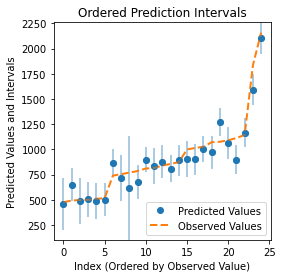

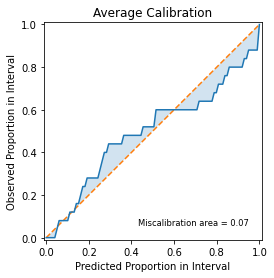

mse: 10779.72,
mean of std: 89.65,
crps: 59.51,
cal_error: 0.08,
mape: 0.09


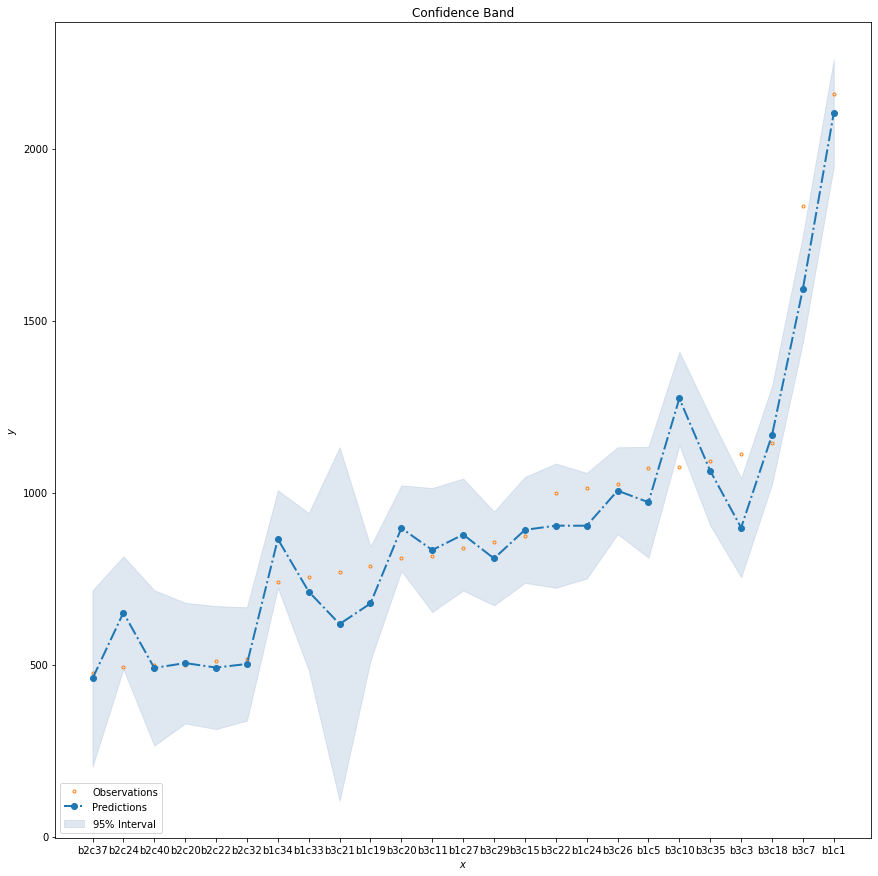

In [56]:
pred, std = random_search.best_estimator_.predict(X_test, return_std=True)
y_true = y_test
y_pred = pred.reshape(-1)
y_std = std.reshape(-1)
battery = df_combined_test['battery'].values
# print('pred_mean : ', y_pred , '\npred_std: ', y_std)

plot_1_2_3(y_pred, y_std, y_true, battery)

mape = mean_absolute_percentage_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
crps = uct.crps_gaussian(y_pred, y_std, y_true)
cal_error = uct.root_mean_squared_calibration_error(y_pred, y_std, y_true)
mean_std = np.mean(y_std)
print('mse: %.2F,\nmean of std: %.2f,\ncrps: %.2f,\ncal_error: %.2f,\nmape: %.2f' % (
   mse, mean_std, crps, cal_error, mape))

### 3.4 Rebuild the model with selected configuration

Parameters:  
{
'kernel__k1__length_scale':  
[1.799588920875949, 53.16071507474129, 1.042846625109511, 22.844252579213908, 12.949233834180538, 46.343061777011755, 45.521236009242735, 0.6953646401027358, 3.9576043384172417],  
'kernel__k1__nu': 2,  
'kernel__k2__noise_level': 0.030240214883120897 
}

In [12]:
length_scale = [1.799588920875949, 53.16071507474129, 1.042846625109511, 22.844252579213908, 12.949233834180538, 46.343061777011755, 45.521236009242735, 0.6953646401027358, 3.9576043384172417]
kernel_1 = gp.kernels.Matern(length_scale=length_scale, length_scale_bounds="fixed", nu=2)
kernel_2 = gp.kernels.WhiteKernel(noise_level=0.03024, noise_level_bounds="fixed")
kernel = kernel_1 + kernel_2 
alpha = 0
gpr = gp.GaussianProcessRegressor(kernel=kernel, alpha=alpha, normalize_y=True, n_restarts_optimizer=5)
gpr.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0,
                         kernel=Matern(length_scale=[1.8, 53.2, 1.04, 22.8, 12.9, 46.3, 45.5, 0.695, 3.96], nu=2) + WhiteKernel(noise_level=0.0302),
                         n_restarts_optimizer=5, normalize_y=True)

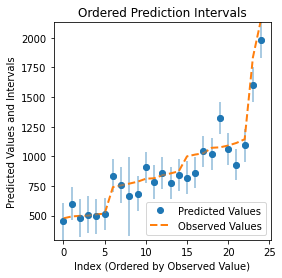

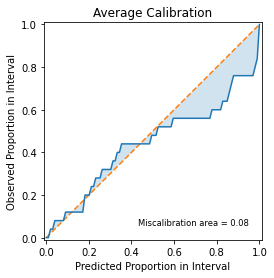

mse: 12170.72,
mean of std: 74.27,
crps: 63.66,
cal_error: 0.10,
mape: 0.09


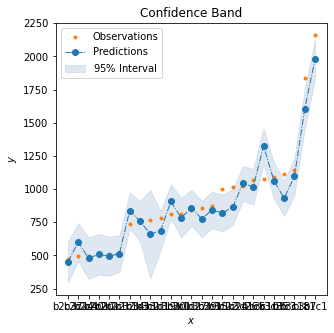

In [26]:
pred, std = gpr.predict(X_test, return_std=True)
y_true = y_test
y_pred = pred.reshape(-1)
y_std = std.reshape(-1)
battery = df_combined_test['battery'].values
# print('pred_mean : ', y_pred , '\npred_std: ', y_std)

plot_1_2_3(y_pred, y_std, y_true, battery)

mape = mean_absolute_percentage_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
crps = uct.crps_gaussian(y_pred, y_std, y_true)
cal_error = uct.root_mean_squared_calibration_error(y_pred, y_std, y_true)
mean_std = np.mean(y_std)
print('mse: %.2F,\nmean of std: %.2f,\ncrps: %.2f,\ncal_error: %.2f,\nmape: %.2f' % (
   mse, mean_std, crps, cal_error, mape))

## 4. Test with RFR

In [60]:
from sklearn.ensemble import RandomForestRegressor
import forestci as fci

### 4.1 Prepare the datas and model

In [61]:
df_combined_train = pd.read_csv('data/MIT/wichtig/df_severson_fei_combined_train.csv')
df_combined_test  = pd.read_csv('data/MIT/wichtig/df_severson_fei_combined_test.csv')
df_combined = pd.read_csv('data/MIT/wichtig/df_severson_fei_combined.csv')

X = df_combined.loc[:, ['intercept_2_100', 'slope_91_100', 'disC_2', 'disC_max_2', 'disC_100', 'F8', 'F9', 'F17']].values
X_train = df_combined_train.loc[:, ['intercept_2_100', 'slope_91_100', 'disC_2', 'disC_max_2', 'disC_100', 'F8', 'F9', 'F17']].values
y_train = df_combined_train['RuL_0.88Ah'].values

X_test = df_combined_test.loc[:, ['intercept_2_100', 'slope_91_100', 'disC_2', 'disC_max_2', 'disC_100', 'F8', 'F9', 'F17']].values
y_test = df_combined_test['RuL_0.88Ah'].values

scaler = preprocessing.StandardScaler()
df_combined
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [92]:
from typing import Union, Tuple, List, Any, NoReturn
import matplotlib

def plot_xy(
    y_pred: np.ndarray,
    y_std: np.ndarray,
    y_true: np.ndarray,
    x: np.ndarray,
    n_subset: Union[int, None] = None,
    ylims: Union[Tuple[float, float], None] = None,
    xlims: Union[Tuple[float, float], None] = None,
    num_stds_confidence_bound: int = 2,
    leg_loc: Union[int, str] = 3,
    ax: Union[matplotlib.axes.Axes, None] = None,
) -> matplotlib.axes.Axes:

    # Create ax if it doesn't exist
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # Order points in order of increasing x
    order = np.argsort(y_true)
    y_pred, y_std, y_true, x = (
        y_pred[order],
        y_std[order],
        y_true[order],
        x[order],
    )

    # Optionally select a subset
    if n_subset is not None:
        [y_pred, y_std, y_true, x] = filter_subset([y_pred, y_std, y_true, x], n_subset)

    intervals = num_stds_confidence_bound * y_std

    h1 = ax.plot(x, y_true, ".", mec="#ff7f0e", mfc="None")
    h2 = ax.plot(x, y_pred, "-.", marker='o', c="#1f77b4", linewidth=2)
    h3 = ax.fill_between(
        x,
        y_pred - intervals,
        y_pred + intervals,
        color="lightsteelblue",
        alpha=0.4,
    )
    ax.legend(
        [h1[0], h2[0], h3],
        ["Observations", "Predictions", "$95\%$ Interval"],
        loc=leg_loc,
    )

    # Format plot
    if ylims is not None:
        ax.set_ylim(ylims)

    if xlims is not None:
        ax.set_xlim(xlims)

    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_title("Confidence Band")
    ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable="box")

    return 


def plot_1_2_3(pred_mean, pred_std, te_y, x, save=None):
    # Warning: problem with the string, need to be correct

    uct.viz.plot_intervals_ordered(pred_mean, pred_std, te_y)
    # plt.gca().set_ylim([1.0,1.1])
    # string = "mu mean_" + str(mu_mean) + "_mu std_" + str(mu_std) + "_label_" + str(label) + ""
    # plt.title(string)
    plt.gcf().set_size_inches(4, 4)
    plt.show()
    if save:
        string = "plt.savefig('data/20211110_Dexuan_RepresentativeSamples/Ordered Prediction Intervals_" + str(
            save) + ".jpg')"
        exec(string)
    uct.viz.plot_calibration(pred_mean, pred_std, te_y)
    # string = "mu mean_" + str(mu_mean) + "_mu std_" + str(mu_std) + "_"
    # plt.title(string)
    plt.gcf().set_size_inches(4, 4)
    plt.show()
    if save:
        string = "plt.savefig('data/20211101_Dexuan_Test_UncertaintyToolbox/Average Calibration_" + str(save) + ".jpg')"
        exec(string)
    
    plot_xy(pred_mean, pred_std, te_y, x)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


class _PredictScorer(_scorer._BaseScorer):

    def _score(self, method_caller, estimator, X, y_true, sample_weight=None):
        y_pred = method_caller(estimator, "predict", X)
        num_test_sample, num_feats = X.shape
        
        if num_test_sample == 25:
            Pseudo_X_train = np.ones((98, num_feats))
        else:
            Pseudo_X_train = np.ones((98 - num_test_sample, num_feats))
        
        V_IJ_unbiased = fci.random_forest_error(estimator, Pseudo_X_train, X, calibrate=True)  # change
        yerr = np.sqrt(abs(V_IJ_unbiased)) + 1e-6
        
        if sample_weight is not None:
            return self._sign * self._score_func(
                y_pred, yerr, y_true, sample_weight=sample_weight, **self._kwargs + 1e-12
            )
        else:
            return self._sign * self._score_func(y_pred, yerr, y_true, **self._kwargs) + 1e-12
        
        
def make_scorer(
    score_func,
    *,
    greater_is_better=True,
    needs_proba=False,
    needs_threshold=False,
    **kwargs,
):
    
    sign = 1 if greater_is_better else -1
    cls = _PredictScorer
    return cls(score_func, sign, kwargs)

CRPS = make_scorer(uct.crps_gaussian, greater_is_better=False)

### 4.2 Tuning

In [87]:
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV, space
from time import time
# from sklearn.utils.fixes import loguniform
from scipy.stats import uniform, loguniform, randint

# Create the random grid
random_grid = {'n_estimators': randint(50, 600),
               'criterion': ["mse"],
               'max_features': ['auto'],
               'max_depth': randint(2, 10),
               'min_samples_split': randint(2, 10),
               'min_samples_leaf': randint(2, 10)
              }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(bootstrap=True)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    cv=4,
    verbose=0,
    random_state=42,
    scoring=CRPS
)

# Fit the random search model
rf_random.fit(X_train, y_train)

No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_sample

D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "D:\ProgramFiles\Anaconda\envs\B

No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_sample

D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "D:\ProgramFiles\Anaconda\envs\B

No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_sample

D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "D:\ProgramFiles\Anaconda\envs\B

No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20


D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "D:\ProgramFiles\Anaconda\envs\B

No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20


D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "D:\ProgramFiles\Anaconda\envs\B

No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_samples <= 20
No calibration with n_sample

D:\ProgramFiles\Anaconda\envs\Battery_EOL_Prediction\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [-143.29820019 -231.57077138 -187.73202892 -104.72048724 -306.34444734
 -148.71172567 -147.96162208 -189.67341122 -149.99542654 -127.75094316
 -158.26935079 -160.75273594  -91.58308502 -107.14163169 -312.17708641
 -121.69140704 -192.06431185 -150.37258763 -310.35628083 -114.53569167
 -149.91322752 -169.23499701 -175.72219644 -138.35248051 -180.45467327
 -147.13896136 -161.63201478 -171.80271342 -150.15829715 -137.62338524
 -130.06898668 -290.62389104 -160.53752557 -231.53517075 -269.55821555
           nan -155.24897004 -279.204255   -146.11255058 -208.91371143
 -167.7118723  -170.47671938  -81.17545783           nan -150.96748099
 -174.96084156 -132.37055413 -147.74617423 -273.15190451 -287.8458292
 -174.09940665 -104.55022389 -121.66999476 -143.68793438 -155.67460298
 -144.15840515 -148.29026561 -190.56165832 -116.4

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'criterion': ['mse', 'mae', 'poisson'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002522068F1C8>,
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002522069BC08>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002522068F588>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002522068F448>},
                   random_state=42,
                   scoring=make_scorer(crps_gaussian, greater_is_better=False))

### 4.3 Results and Visualization

In [91]:
report(rf_random.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: -81.175 (std: 22.490)
Parameters: {'criterion': 'mse', 'max_depth': 28, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 239}

Model with rank: 2
Mean validation score: -91.583 (std: 26.715)
Parameters: {'criterion': 'mse', 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 14, 'n_estimators': 100}

Model with rank: 3
Mean validation score: -104.550 (std: 35.918)
Parameters: {'criterion': 'poisson', 'max_depth': 21, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 659}

Model with rank: 4
Mean validation score: -104.720 (std: 35.761)
Parameters: {'criterion': 'poisson', 'max_depth': 23, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 24, 'n_estimators': 511}

Model with rank: 5
Mean validation score: -107.142 (std: 35.504)
Parameters: {'criterion': 'mae', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 2, 

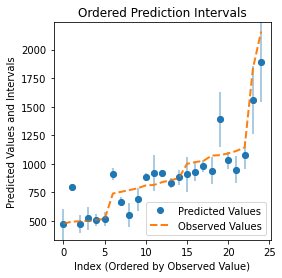

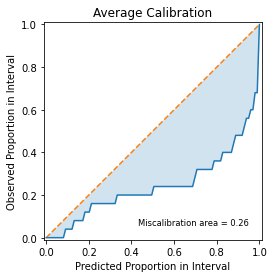

mse: 21118.47,
mean of std: 53.63,
crps: 86.80,
cal_error: 0.30,
mape: 0.12


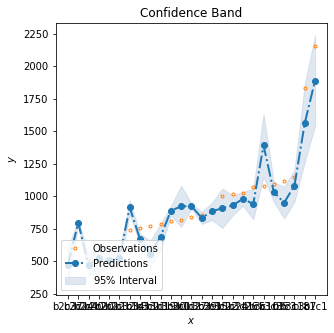

In [90]:
forest = rf_random.best_estimator_
# forest = bayessearch.best_estimator_
# Calculate the variance
V_IJ_unbiased = fci.random_forest_error(forest, X_train, X_test, calibrate=False)
y_pred = forest.predict(X_test)
y_std = np.sqrt(abs(V_IJ_unbiased))
y_true = y_test
battery = df_combined_test['battery'].values
plot_1_2_3(y_pred, y_std, y_true, battery)

mape = mean_absolute_percentage_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
crps = uct.crps_gaussian(y_pred, y_std, y_true)
cal_error = uct.root_mean_squared_calibration_error(y_pred, y_std, y_true)
mean_std = np.mean(y_std)
print('mse: %.2F,\nmean of std: %.2f,\ncrps: %.2f,\ncal_error: %.2f,\nmape: %.2f' % (
   mse, mean_std, crps, cal_error, mape))